# Neural Style Transfer with tf.keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

In this tutorial, we will learn how to use deep learning to compose images in the style of another image (ever wish you could paint like Picasso or Van Gogh?). This is known as **neural style transfer**! This is a technique outlined in [Leon A. Gatys' paper, A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576), which is a great read, and you should definitely check it out. 

But, what is neural style transfer?

Neural style transfer is an optimization technique used to take three images, a **content** image, a **style reference** image (such as an artwork by a famous painter), and the **input** image you want to style -- and blend them together such that the input image is transformed to look like the content image, but “painted” in the style of the style image.


For example, let’s take an image of this turtle and Katsushika Hokusai's *The Great Wave off Kanagawa*:

<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/Green_Sea_Turtle_grazing_seagrass.jpg?raw=1" alt="Drawing" style="width: 200px;"/>
<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/The_Great_Wave_off_Kanagawa.jpg?raw=1" alt="Drawing" style="width: 200px;"/>

[Image of Green Sea Turtle](https://commons.wikimedia.org/wiki/File:Green_Sea_Turtle_grazing_seagrass.jpg)
-By P.Lindgren [CC BY-SA 3.0  (https://creativecommons.org/licenses/by-sa/3.0)], from Wikimedia Commons


Now how would it look like if Hokusai decided to paint the picture of this Turtle exclusively with this style? Something like this?

<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/wave_turtle.png?raw=1" alt="Drawing" style="width: 500px;"/>

Is this magic or just deep learning? Fortunately, this doesn’t involve any witchcraft: style transfer is a fun and interesting technique that showcases the capabilities and internal representations of neural networks.  

The principle of neural style transfer is to define two distance functions, one that describes how different the content of two images are , $L_{content}$, and one that describes the difference between two images in terms of their style, $L_{style}$. Then, given three images, a desired style image, a desired content image, and the input image (initialized with the content image), we try to transform the input image to minimize the content distance with the content image and its style distance with the style image. 
In summary, we’ll take the base input image, a content image that we want to match, and the style image that we want to match. We’ll transform the base input image by minimizing the content and style distances (losses) with backpropagation, creating an image that matches the content of the content image and the style of the style image. 

### Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts

* **Eager Execution** - use TensorFlow's imperative programming environment that evaluates operations immediately 
  * [Learn more about eager execution](https://www.tensorflow.org/programmers_guide/eager)
  * [See it in action](https://www.tensorflow.org/get_started/eager)
* ** Using [Functional API](https://keras.io/getting-started/functional-api-guide/) to define a model** - we'll build a subset of our model that will give us access to the necessary intermediate activations using the Functional API 
* **Leveraging feature maps of a pretrained model** - Learn how to use pretrained models and their feature maps 
* **Create custom training loops** - we'll examine how to set up an optimizer to minimize a given loss with respect to input parameters

### We will follow the general steps to perform style transfer:

1. Visualize data
2. Basic Preprocessing/preparing our data
3. Set up loss functions 
4. Create model
5. Optimize for loss function

**Audience:** This post is geared towards intermediate users who are comfortable with basic machine learning concepts. To get the most out of this post, you should: 
* Read [Gatys' paper](https://arxiv.org/abs/1508.06576) - we'll explain along the way, but the paper will provide a more thorough understanding of the task
* [Understand reducing loss with gradient descent](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent)

**Time Estimated**: 30 min


## Setup

### Images Directory

In [21]:
print(sys.executable)
print(sys.version)

c:\Users\esdan\Desktop\style-transfer\venv\Scripts\python.exe
3.8.4 (tags/v3.8.4:dfa645a, Jul 13 2020, 16:46:45) [MSC v.1924 64 bit (AMD64)]


In [22]:
from pathlib import Path

img_dir = Path('datasets', 'tutorial')
if not img_dir.exists() or not img_dir.is_dir():
    raise FileNotFoundError('The image directory does not exist')
else:
    print('\n'.join([str(f) for f in img_dir.iterdir() if f.is_file()]))

datasets\tutorial\1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
datasets\tutorial\Green_Sea_Turtle_grazing_seagrass.jpg
datasets\tutorial\Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
datasets\tutorial\The_Great_Wave_off_Kanagawa.jpg
datasets\tutorial\Tuebingen_Neckarfront.jpg
datasets\tutorial\Vassily_Kandinsky,_1913_-_Composition_7.jpg


### Import and configure modules

In [23]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [24]:
# %tensorflow_version 1.x
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [25]:
# Set up some global values here
content_path = Path(img_dir, 'Green_Sea_Turtle_grazing_seagrass.jpg')
style_path = Path(img_dir, 'The_Great_Wave_off_Kanagawa.jpg')

## Visualize the input

In [26]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [27]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

These are input content and style images. We hope to "create" an image with the content of our content image, but with the style of the style image. 

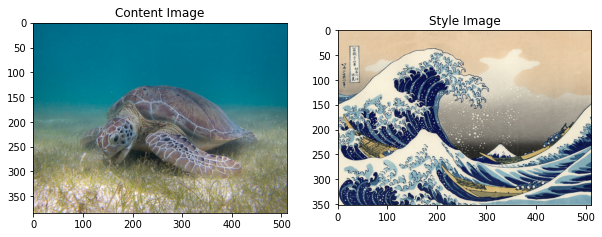

In [28]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

## Prepare the data
Let's create methods that will allow us to load and preprocess our images easily. We perform the same preprocessing process as are expected according to the VGG training process. VGG networks are trained on image with each channel normalized by `mean = [103.939, 116.779, 123.68]`and with channels BGR.

In [29]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In order to view the outputs of our optimization, we are required to perform the inverse preprocessing step. Furthermore, since our optimized image may take its values anywhere between $- \infty$ and $\infty$, we must clip to maintain our values from within the 0-255 range.   

In [30]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

### Define content and style representations
In order to get both the content and style representations of our image, we will look at some intermediate layers within our model. As we go deeper into the model, these intermediate layers represent higher and higher order features. In this case, we are using the network architecture VGG19, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from our images. For an input image, we will try to match the corresponding style and content target representations at these intermediate layers. 

#### Why intermediate layers?

You may be wondering why these intermediate outputs within our pretrained image classification network allow us to define style and content representations. At a high level, this phenomenon can be explained by the fact that in order for a network to perform image classification (which our network has been trained to do), it must understand the image. This involves taking the raw image as input pixels and building an internal representation through transformations that turn the raw image pixels into a complex understanding of the features present within the image. This is also partly why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g., cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed in and the classification label is output, the model serves as a complex feature extractor; hence by accessing intermediate layers, we’re able to describe the content and style of input images. 


Specifically we’ll pull out these intermediate layers from our network: 


In [31]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the Model 
In this case, we load [VGG19](https://keras.io/applications/#vgg19), and feed in our input tensor to the model. This will allow us to extract the feature maps (and subsequently the content and style representations) of the content, style, and generated images.

We use VGG19, as suggested in the paper. In addition, since VGG19 is a relatively simple model (compared with ResNet, Inception, etc) the feature maps actually work better for style transfer. 

In order to access the intermediate layers corresponding to our style and content feature maps, we get the corresponding outputs and using the Keras [**Functional API**](https://keras.io/getting-started/functional-api-guide/), we define our model with the desired output activations. 

With the Functional API defining a model simply involves defining the input and output: 

`model = Model(inputs, outputs)`

In [32]:
def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In the above code snippet, we’ll load our pretrained image classification network. Then we grab the layers of interest as we defined earlier. Then we define a Model by setting the model’s inputs to an image and the outputs to the outputs of the style and content layers. In other words, we created a model that will take an input image and output the content and style intermediate layers! 


## Define and create our loss functions (content and style distances)

### Content Loss

Our content loss definition is actually quite simple. We’ll pass the network both the desired content image and our base input image. This will return the intermediate layer outputs (from the layers defined above) from our model. Then we simply take the euclidean distance between the two intermediate representations of those images.  

More formally, content loss is a function that describes the distance of content from our output image $x$ and our content image, $p$. Let $C_{nn}$ be a pre-trained deep convolutional neural network. Again, in this case we use [VGG19](https://keras.io/applications/#vgg19). Let $X$ be any image, then $C_{nn}(X)$ is the network fed by X. Let $F^l_{ij}(x) \in C_{nn}(x)$ and $P^l_{ij}(p) \in C_{nn}(p)$ describe the respective intermediate feature representation of the network with inputs $x$ and $p$ at layer $l$. Then we describe the content distance (loss) formally as: $$L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2$$

We perform backpropagation in the usual way such that we minimize this content loss. We thus change the initial image until it generates a similar response in a certain layer (defined in content_layer) as the original content image.

This can be implemented quite simply. Again it will take as input the feature maps at a layer L in a network fed by x, our input image, and p, our content image, and return the content distance.



### Computing content loss
We will actually add our content losses at each desired layer. This way, each iteration when we feed our input image through the model (which in eager is simply `model(input_image)`!) all the content losses through the model will be properly compute and because we are executing eagerly, all the gradients will be computed. 

In [33]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

## Style Loss

Computing style loss is a bit more involved, but follows the same principle, this time feeding our network the base input image and the style image. However, instead of comparing the raw intermediate outputs of the base input image and the style image, we instead compare the Gram matrices of the two outputs. 

Mathematically, we describe the style loss of the base input image, $x$, and the style image, $a$, as the distance between the style representation (the gram matrices) of these images. We describe the style representation of an image as the correlation between different filter responses given by the Gram matrix  $G^l$, where $G^l_{ij}$ is the inner product between the vectorized feature map $i$ and $j$ in layer $l$. We can see that $G^l_{ij}$ generated over the feature map for a given image represents the correlation between feature maps $i$ and $j$. 

To generate a style for our base input image, we perform gradient descent from the content image to transform it into an image that matches the style representation of the original image. We do so by minimizing the mean squared distance between the feature correlation map of the style image and the input image. The contribution of each layer to the total style loss is described by
$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$

where $G^l_{ij}$ and $A^l_{ij}$ are the respective style representation in layer $l$ of $x$ and $a$. $N_l$ describes the number of feature maps, each of size $M_l = height * width$. Thus, the total style loss across each layer is 
$$L_{style}(a, x) = \sum_{l \in L} w_l E_l$$
where we weight the contribution of each layer's loss by some factor $w_l$. In our case, we weight each layer equally ($w_l =\frac{1}{|L|}$)

### Computing style loss
Again, we implement our loss as a distance metric . 

In [34]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

## Apply style transfer to our images


### Run Gradient Descent 
If you aren't familiar with gradient descent/backpropagation or need a refresher, you should definitely check out this [awesome resource](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent).

In this case, we use the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)* optimizer in order to minimize our loss. We iteratively update our output image such that it minimizes our loss: we don't update the weights associated with our network, but instead we train our input image to minimize loss. In order to do this, we must know how we calculate our loss and gradients. 

\* Note that L-BFGS, which if you are familiar with this algorithm is recommended, isn’t used in this tutorial because a primary motivation behind this tutorial was to illustrate best practices with eager execution, and, by using Adam, we can demonstrate the autograd/gradient tape functionality with custom training loops.


We’ll define a little helper function that will load our content and style image, feed them forward through our network, which will then output the content and style feature representations from our model. 

In [35]:
def get_feature_representations(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

### Computing the loss and gradients
Here we use [**tf.GradientTape**](https://www.tensorflow.org/programmers_guide/eager#computing_gradients) to compute the gradient. It allows us to take advantage of the automatic differentiation available by tracing operations for computing the gradient later. It records the operations during the forward pass and then is able to compute the gradient of our loss function with respect to our input image for the backwards pass.

In [36]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

Then computing the gradients is easy:

In [37]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

### Optimization loop

In [41]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.optimizers.Adam(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

In [42]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'Adam'

In [20]:
Image.fromarray(best)

NameError: name 'best' is not defined

To download the image from Colab uncomment the following code:

In [0]:
#from google.colab import files
#files.download('wave_turtle.png')

## Visualize outputs
We "deprocess" the output image in order to remove the processing that was applied to it. 

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

In [0]:
show_results(best, content_path, style_path)

## Try it on other images
Image of Tuebingen 

Photo By: Andreas Praefcke [GFDL (http://www.gnu.org/copyleft/fdl.html) or CC BY 3.0  (https://creativecommons.org/licenses/by/3.0)], from Wikimedia Commons

### Starry night + Tuebingen

In [0]:
best_starry_night, best_loss = run_style_transfer('/tmp/nst/Tuebingen_Neckarfront.jpg',
                                                  '/tmp/nst/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

In [0]:
show_results(best_starry_night, '/tmp/nst/Tuebingen_Neckarfront.jpg',
             '/tmp/nst/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

### Pillars of Creation + Tuebingen

In [0]:
best_poc_tubingen, best_loss = run_style_transfer('/tmp/nst/Tuebingen_Neckarfront.jpg', 
                                                  '/tmp/nst/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')

In [0]:
show_results(best_poc_tubingen, 
             '/tmp/nst/Tuebingen_Neckarfront.jpg',
             '/tmp/nst/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')

### Kandinsky Composition 7 + Tuebingen

In [0]:
best_kandinsky_tubingen, best_loss = run_style_transfer('/tmp/nst/Tuebingen_Neckarfront.jpg', 
                                                  '/tmp/nst/Vassily_Kandinsky,_1913_-_Composition_7.jpg')

In [0]:
show_results(best_kandinsky_tubingen, 
             '/tmp/nst/Tuebingen_Neckarfront.jpg',
             '/tmp/nst/Vassily_Kandinsky,_1913_-_Composition_7.jpg')

### Pillars of Creation + Sea Turtle

In [0]:
best_poc_turtle, best_loss = run_style_transfer('/tmp/nst/Green_Sea_Turtle_grazing_seagrass.jpg', 
                                                  '/tmp/nst/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')

In [0]:
show_results(best_poc_turtle, 
             '/tmp/nst/Green_Sea_Turtle_grazing_seagrass.jpg',
             '/tmp/nst/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')

## Key Takeaways

### What we covered:

* We built several different loss functions and used backpropagation to transform our input image in order to minimize these losses
  * In order to do this we had to load in a **pretrained model** and use its learned feature maps to describe the content and style representation of our images.
    * Our main loss functions were primarily computing the distance in terms of these different representations
* We implemented this with a custom model and **eager execution**
  * We built our custom model with the Functional API 
  * Eager execution allows us to dynamically work with tensors, using a natural python control flow
  * We manipulated tensors directly, which makes debugging and working with tensors easier. 
* We iteratively updated our image by applying our optimizers update rules using **tf.gradient**. The optimizer minimized a given loss with respect to our input image. 


**[Image of Tuebingen](https://commons.wikimedia.org/wiki/File:Tuebingen_Neckarfront.jpg)** 
Photo By: Andreas Praefcke [GFDL (http://www.gnu.org/copyleft/fdl.html) or CC BY 3.0  (https://creativecommons.org/licenses/by/3.0)], from Wikimedia Commons

**[Image of Green Sea Turtle](https://commons.wikimedia.org/wiki/File:Green_Sea_Turtle_grazing_seagrass.jpg)**
By P.Lindgren [CC BY-SA 3.0 (https://creativecommons.org/licenses/by-sa/3.0)], from Wikimedia Commons

